In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [ ]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & physeq.Bulk.m$Month %in% c("August", "November")),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

In [ ]:
%%R
levels(physeq.Bulk.m$Month)
sample_data(physeq.Bulk)$Month<-factor(sample_data(physeq.Bulk)$Month, levels=c("November","August"))


In [ ]:
%%R
get_l2fc = function(physeq.obj, Land_Management, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Land_Management == Land_Management),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Month)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [ ]:
%%R
physeq.m =  physeq.Bulk %>% sample_data 
levels(physeq.m$Month)

In [ ]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Land_Management) %>%
   distinct() %>%
    arrange(Land_Management) 
  

sdm

In [ ]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

In [ ]:
%%R
#For testing method
test = head(sdms, 5)
test

In [ ]:
%%R
physeq.Bulk.m = sample_data(physeq.Bulk)
levels(physeq.Bulk.m$Month)

In [ ]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

In [ ]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

In [ ]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

In [ ]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [ ]:
%%R
df.l2fc$Month[df.l2fc$log2FoldChange < 0] = "November"
df.l2fc$Month[df.l2fc$log2FoldChange > 0] = "August"

In [ ]:
%%R
write.table(df.l2fc, "data/l2fc_AugvsNov_all", row.names = FALSE, sep = ",")

In [12]:
%%R
df.l2fc = read.table("data/l2fc_AugvsNov_all", header = TRUE, sep = ",")

In [13]:
%%R
tail(df.l2fc)

       Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
320313             PTR               0.95   OTU.314      0.6470480 0.3415242
320314             PTR               0.95 OTU.29650     -0.0389671 0.3137666
320315             PTR               0.95 OTU.19298     -0.8844065 0.3674922
320316             PTR               0.95    OTU.88      0.1738408 0.2150939
320317             PTR               0.95   OTU.667      0.1283259 0.3636272
320318             PTR               0.95  OTU.1006      0.3713480 0.3252246
            padj    Rank1           Rank2                            Rank3
320313 0.5418896 Bacteria __Acidobacteria __Candidatus_Chloracidobacterium
320314 0.9913119 Bacteria __Acidobacteria                           __RB41
320315 0.3369228 Bacteria __Acidobacteria                           __RB41
320316 0.8960874 Bacteria __Acidobacteria                           __RB41
320317 0.9776757 Bacteria __Acidobacteria                          __11-24
320318 0.86

In [14]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05            38
2               0.10            46
3               0.15            46
4               0.20            53
5               0.25            54
6               0.30            54


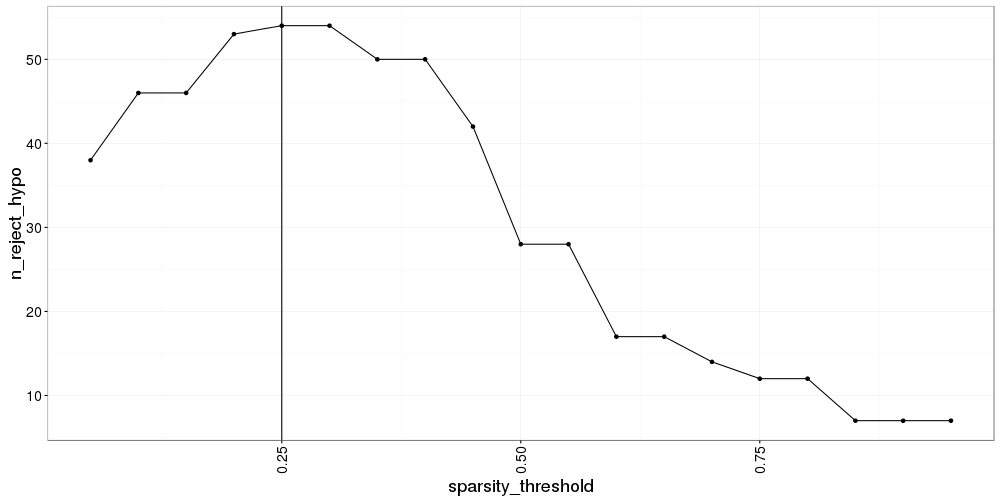

In [15]:
%%R -w 1000 -h 500

#df.l2fc.rejH.2 = filter(df.l2fc.rejH, sample.size == 15000)
ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) + geom_vline(xintercept = 0.25) +
    geom_point() +
    geom_line() +
    #facet_grid(, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
        

In [16]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05            38
2               0.10            46
3               0.15            46


In [17]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.25


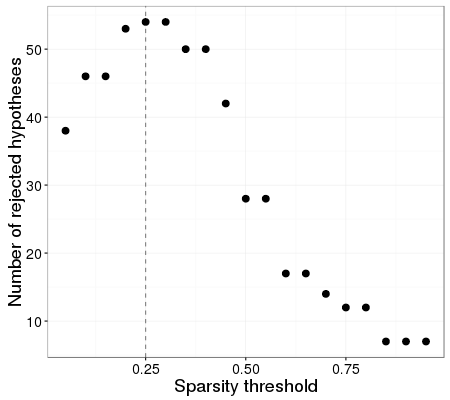

In [21]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [22]:
%%R
ggsave('data/figs/Sparsity_Thres.jpg', width = 4.5, height = 4)

In [19]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 21460


In [20]:
%%R
head(df.l2fc.f)

  Land_Management sparsity_threshold      OTU log2FoldChange     lfcSE
1             NTH               0.25 OTU.4940     -0.5733776 0.5886599
2             NTH               0.25 OTU.5493      0.2285200 0.5421605
3             NTH               0.25 OTU.1739     -0.4385353 0.5827288
4             NTH               0.25 OTU.1813      0.4330987 0.5592486
5             NTH               0.25  OTU.778     -0.0417744 0.3577181
6             NTH               0.25 OTU.5511     -0.5325709 0.5906597
       padj    Rank1            Rank2          Rank3                  Rank4
1 0.9942153 Bacteria  __Acidobacteria        __32-21 __uncultured_bacterium
2 0.9942153 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium
3 0.9942153 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
4 0.9942153 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
5 0.9942153 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
6 0.9942153 Bacteria __Planctomycetes __Pla4_li

In [ ]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_AugNov.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_AugNov.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [24]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_AugNov.txt', sep='\t', header = TRUE)

In [25]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub('__', "", df.l2fc$Rank7)

In [26]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Land_Management) %>% summarise(resp = n())
resp %>% as.data.frame

     Month Land_Management resp
1   August             NTR    1
2   August             PTH   27
3   August             PTR   17
4 November             NTH    1
5 November             NTR    5
6 November             PTH    2
7 November             PTR    1


####Function arguments

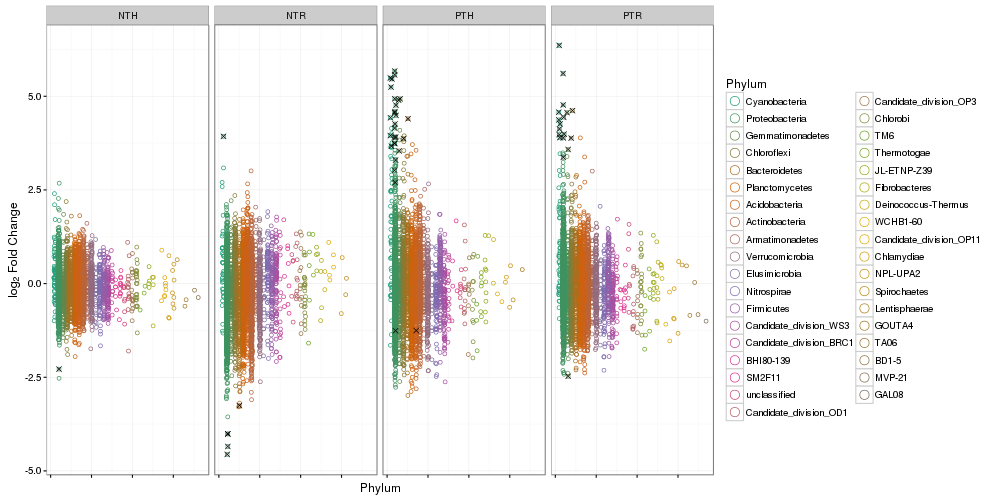

In [27]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

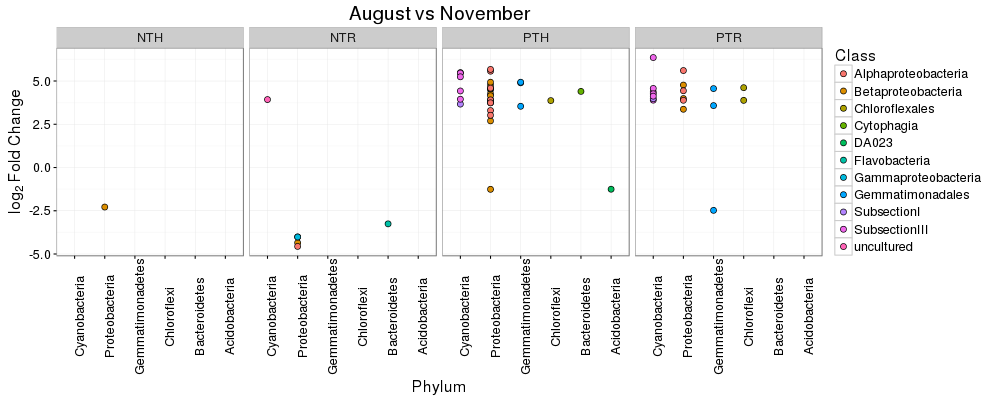

In [28]:
%%R -w 1000 -h 400
d = df.l2fc

d = filter(d, padj2 <=0.10)
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = Rank2, y = log2FoldChange, fill = Rank3))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2.5)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", fill = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4))) +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +
        ggtitle("August vs November")


p

In [29]:
%%R
ggsave('data/figs/AugNov_bact.jpg', p, width=12, height=6)


In [30]:
%%R
d %>% filter(padj2 <=0.10) %>% group_by(Rank2, Rank3, Rank4) %>% summarise(counts = n()) %>% as.data.frame

              Rank2               Rank3                Rank4 counts
1     Cyanobacteria         SubsectionI              FamilyI      2
2     Cyanobacteria       SubsectionIII              FamilyI     11
3     Cyanobacteria          uncultured                 <NA>      1
4    Proteobacteria Alphaproteobacteria      Caulobacterales      1
5    Proteobacteria Alphaproteobacteria      Rhodobacterales      5
6    Proteobacteria Alphaproteobacteria     Sphingomonadales      5
7    Proteobacteria  Betaproteobacteria      Burkholderiales     14
8    Proteobacteria  Betaproteobacteria     Nitrosomonadales      1
9    Proteobacteria Gammaproteobacteria      Pseudomonadales      1
10   Proteobacteria Gammaproteobacteria      Xanthomonadales      1
11 Gemmatimonadetes    Gemmatimonadales    Gemmatimonadaceae      6
12      Chloroflexi      Chloroflexales      Chloroflexaceae      3
13    Bacteroidetes          Cytophagia         Cytophagales      1
14    Bacteroidetes       Flavobacteria     Flav

In [31]:
%%R
filter(df.l2fc, Land_Management == 'NTR' & padj2 <=0.10)

  Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
1             NTR               0.25   OTU.338       3.929580 0.6992557
2             NTR               0.25    OTU.10      -3.254443 0.5166829
3             NTR               0.25 OTU.29210      -4.347869 0.7941821
4             NTR               0.25    OTU.25      -4.009922 0.5076301
5             NTR               0.25     OTU.7      -4.014299 0.6752516
6             NTR               0.25  OTU.1377      -4.558946 0.8122937
          padj    Rank1          Rank2               Rank3            Rank4
1 2.081168e-05 Bacteria  Cyanobacteria          uncultured             <NA>
2 7.826742e-07 Bacteria  Bacteroidetes       Flavobacteria Flavobacteriales
3 3.810961e-05 Bacteria Proteobacteria  Betaproteobacteria  Burkholderiales
4 1.462961e-11 Bacteria Proteobacteria  Betaproteobacteria  Burkholderiales
5 4.809800e-06 Bacteria Proteobacteria Gammaproteobacteria  Pseudomonadales
6 2.081168e-05 Bacteria Proteobacteria A

## Looking at similarity of Responders in Treatments in various month combinations

In [32]:
%%R
df.AugApril = read.table('data/l2fc_sparse-maxRejH_AugApril.txt', sep = '\t', header = TRUE)
df.AugApril = select(df.AugApril, Land_Management, OTU, log2FoldChange, padj2, Month)

df.AprilNov = read.table('data/l2fc_sparse-maxRejH_AprilvsNov.txt', sep = '\t', header = TRUE)
df.AprilNov = select(df.AprilNov, Land_Management, OTU, log2FoldChange, padj2, Month)

df.l2fc = select(df.l2fc, Land_Management, OTU, log2FoldChange, padj2, Month, Rank2, Rank5)


In [33]:
%%R
df.l2fc = plyr::rename(df.l2fc, c('log2FoldChange' = 'LFC_AugNov') )
df.l2fc = plyr::rename(df.l2fc, c('padj2' = 'p_AugNov') )
df.l2fc = plyr::rename(df.l2fc, c('Month' = 'Month_AugNov') )


df.AugApril = plyr::rename(df.AugApril, c('log2FoldChange' = 'LFC_AugAp') )
df.AugApril = plyr::rename(df.AugApril, c('padj2' = 'p_AugAp') )
df.AugApril = plyr::rename(df.AugApril, c('Month' = 'Month_AugAp') )


df.AprilNov = plyr::rename(df.AprilNov, c('log2FoldChange' = 'LFC_ApNov') )
df.AprilNov = plyr::rename(df.AprilNov, c('padj2' = 'p_ApNov') )
df.AprilNov = plyr::rename(df.AprilNov, c('Month' = 'Month_ApNov') )

In [34]:
%%R
print(head(df.l2fc))
print(head(df.AugApril))
print(head(df.AprilNov))

  Land_Management      OTU LFC_AugNov p_AugNov Month_AugNov          Rank2
1             NTH OTU.4940 -0.5733776        1     November  Acidobacteria
2             NTH OTU.5493  0.2285200        1       August    Chloroflexi
3             NTH OTU.1739 -0.4385353        1     November Planctomycetes
4             NTH OTU.1813  0.4330987        1       August Planctomycetes
5             NTH  OTU.778 -0.0417744        1     November Planctomycetes
6             NTH OTU.5511 -0.5325709        1     November Planctomycetes
  Rank5
1  <NA>
2  <NA>
3  <NA>
4  <NA>
5  <NA>
6  <NA>
  Land_Management      OTU  LFC_AugAp   p_AugAp Month_AugAp
1             NTH OTU.4940 -0.6085073 0.9999941       April
2             NTH OTU.1739  0.9471104 0.9999941      August
3             NTH OTU.1813  1.5159033 0.9999941      August
4             NTH  OTU.778  0.3206218 0.9999941      August
5             NTH OTU.5664 -0.1447653 0.9999941       April
6             NTH OTU.2180  0.5594042 0.9999941      August

In [35]:
%%R
print(length(df.l2fc$OTU))
print(length(df.AugApril$OTU))
print(length(df.AprilNov$OTU))

[1] 21460
[1] 15640
[1] 14740


In [36]:
%%R
df.tot = full_join(df.l2fc, df.AugApril, by = c('OTU', 'Land_Management'))

In [37]:
%%R
df.tot2 = full_join(df.tot, df.AprilNov, by = c('OTU', 'Land_Management'))

In [38]:
%%R
write.csv(df.tot2, 'data/Month_Comparisons_byTreat.csv')

In [39]:
%%R
(df.tot2) %>% arrange(OTU) %>% head()

  Land_Management    OTU LFC_AugNov    p_AugNov Month_AugNov          Rank2
1             NTH  OTU.1  0.3357979 1.000000000       August Actinobacteria
2             NTR  OTU.1 -0.2605101 1.000000000     November Actinobacteria
3             PTH  OTU.1  0.4616183 1.000000000       August Actinobacteria
4             PTR  OTU.1  0.1796655 1.000000000       August Actinobacteria
5             NTH OTU.10 -0.5211306 1.000000000     November  Bacteroidetes
6             NTR OTU.10 -3.2544429 0.001069474     November  Bacteroidetes
              Rank5   LFC_AugAp   p_AugAp Month_AugAp  LFC_ApNov p_ApNov
1      Arthrobacter -0.34725365 0.9999941       April -0.6784566       1
2      Arthrobacter -0.63990579 0.9999941       April -0.3543840       1
3      Arthrobacter -0.15450979 0.9999941       April -0.6035091       1
4      Arthrobacter  0.01722637 0.9999941      August -0.1748655       1
5 Flavobacteriaceae -1.13756390 0.9999941       April -0.5027809       1
6 Flavobacteriaceae -5.0067170

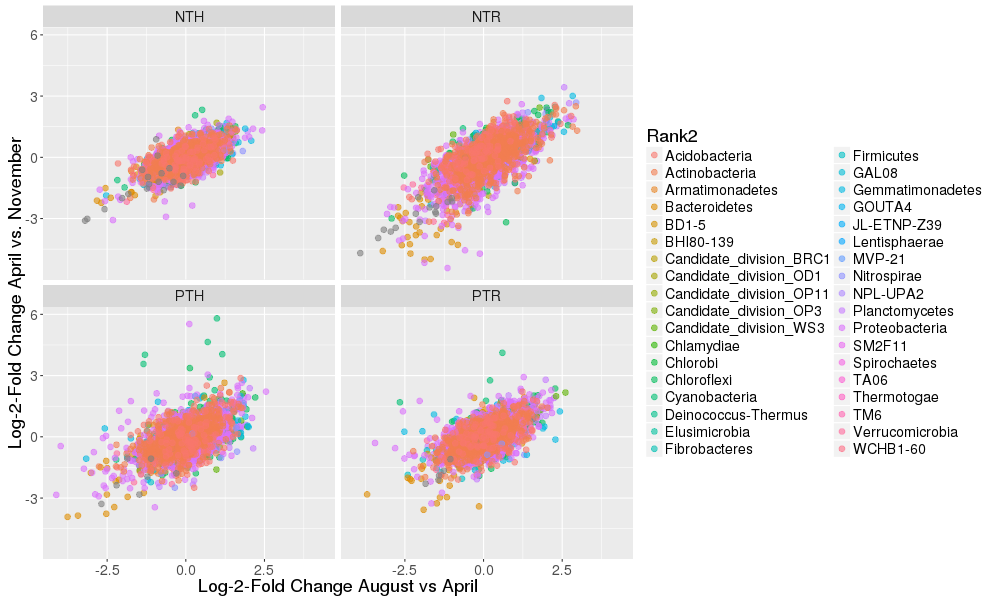

In [40]:
%%R -w 1000 -h 600
p = ggplot(df.tot2, aes(LFC_ApNov, LFC_AugAp)) + geom_point(aes(color = Rank2), alpha = 0.6, size = 2.5) +
     # geom_path(data=test, aes(x=x, y=y), size=1, linetype=1) +

    facet_wrap(~Land_Management) +
     theme(
        text = element_text(size=18)) + xlab('Log-2-Fold Change August vs April') + 
        ylab('Log-2-Fold Change April vs. November') 
p

In [41]:
%%R
head(df.tot2)

df.tot2$Resp_status[df.tot2$p_AugAp <= 0.10 & df.tot2$LFC_AugAp < 0] = "Spring Responder"
df.tot2$Resp_status[df.tot2$p_AugNov <= 0.10 & df.tot2$LFC_AugNov < 0] = "Fall Responder"
df.tot2$Resp_status[df.tot2$p_AugAp <= 0.10 & df.tot2$LFC_AugAp > 0] = "Summer Responder"
df.tot2$Resp_status[df.tot2$p_AugNov <= 0.10 & df.tot2$LFC_AugNov > 0] = "Summer Responder"


In [42]:
%%R
write.csv(df.tot2, 'data/SpringSumFall_Resp.csv')

In [43]:
%%R
phyl.tokeep = filter(df.tot2, !is.na(Resp_status))
head(phyl.tokeep)
unique(phyl.tokeep$Rank2)

 [1] "Proteobacteria"   "Nitrospirae"      "Cyanobacteria"    "Bacteroidetes"   
 [5] "Verrucomicrobia"  "Actinobacteria"   "Chloroflexi"      "Gemmatimonadetes"
 [9] "Acidobacteria"    NA                


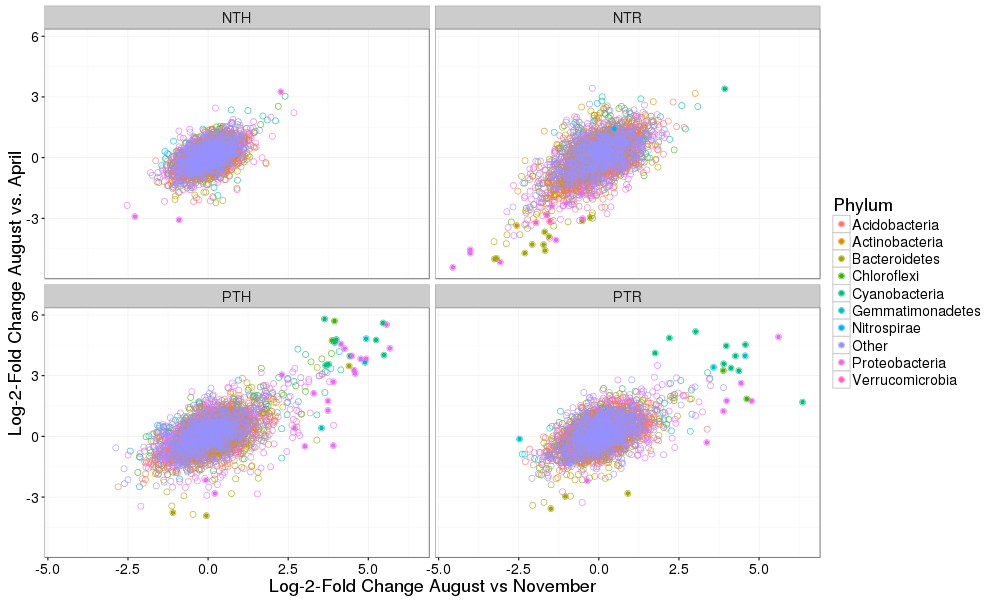

In [44]:
%%R -w 1000 -h 600
df.keep = filter(df.tot2, Rank2 %in% phyl.tokeep$Rank2)
df.keep$Group = df.keep$Rank2
df.nokeep = filter(df.tot2, !(Rank2 %in% phyl.tokeep$Rank2))
df.nokeep$Group = 'Other'

df.filt = rbind(df.keep, df.nokeep)


SpFall_resp = filter(df.tot2, Resp_status %in% c('Spring Responder', 'Fall Responder'))
Sum_resp = filter(df.tot2, Resp_status %in% c('Summer Responder'))


p = ggplot(df.filt, aes(x = LFC_AugNov, y = LFC_AugAp)) + geom_point(aes(color = Group), alpha = 0.8,
                                                                     size = 2.5, shape = 1) +
    facet_wrap(~Land_Management) +
    geom_point(data = SpFall_resp, aes(color = Rank2), alpha = 1) +
    geom_point(data = Sum_resp, aes(color = Rank2), alpha = 1) + theme_bw() +
     theme(
        text = element_text(size=18)) + xlab('Log-2-Fold Change August vs November') + 
        ylab('Log-2-Fold Change August vs. April')  + scale_color_discrete(name = 'Phylum')

p

In [45]:
%%R
ggsave('data/figs/Spring_Summer_Fall_resp.pdf', p, width=12, height=8)


In [46]:
%%R
Sum_resp %>% group_by(Rank2, Rank5) %>% summarise(n()) 

Source: local data frame [19 x 3]
Groups: Rank2 [?]

              Rank2                Rank5   n()
              (chr)                (chr) (int)
1     Bacteroidetes        Cytophagaceae     1
2       Chloroflexi         Chloroflexus     4
3     Cyanobacteria         Leptolyngbya     6
4     Cyanobacteria          Microcoleus     2
5     Cyanobacteria           Phormidium     2
6     Cyanobacteria           uncultured     1
7     Cyanobacteria uncultured_bacterium     1
8     Cyanobacteria                   NA     8
9  Gemmatimonadetes         Gemmatimonas     1
10 Gemmatimonadetes           uncultured     4
11      Nitrospirae            0319-6A21     1
12   Proteobacteria     Caulobacteraceae     1
13   Proteobacteria       Comamonadaceae     9
14   Proteobacteria   Erythrobacteraceae     3
15   Proteobacteria     Rhodobacteraceae     5
16   Proteobacteria       Rhodocyclaceae     2
17   Proteobacteria    Sphingomonadaceae     1
18   Proteobacteria     Xanthomonadaceae     1
19   Pr

In [47]:
%%R
df.keep %>% head %>% as.data.frame

  Land_Management       OTU  LFC_AugNov p_AugNov Month_AugNov          Rank2
1             NTH  OTU.4940 -0.57337755        1     November  Acidobacteria
2             NTH  OTU.5493  0.22852000        1       August    Chloroflexi
3             NTH  OTU.4118 -0.09789985        1     November           <NA>
4             NTH  OTU.2228 -0.02105224        1     November Proteobacteria
5             NTH OTU.27582 -0.32468291        1     November Proteobacteria
6             NTH  OTU.1797  0.11925593        1       August    Nitrospirae
           Rank5  LFC_AugAp   p_AugAp Month_AugAp   LFC_ApNov p_ApNov
1           <NA> -0.6085073 0.9999941       April -0.06290669       1
2           <NA>         NA        NA        <NA>          NA      NA
3           <NA> -0.1407430 0.9999941       April -0.06319689       1
4 Nitrospinaceae  0.7261749 0.9999941      August  0.86305989       1
5 Nitrospinaceae         NA        NA        <NA>          NA      NA
6 Nitrospiraceae  0.4534887 0.9999941    

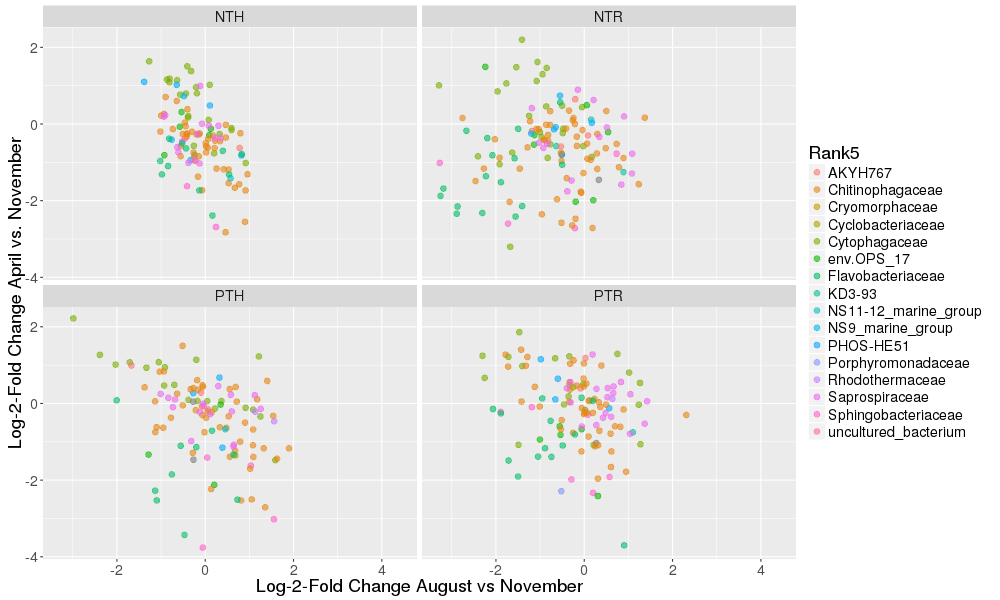

In [48]:
%%R -w 1000 -h 600
df.bact = filter(df.tot2, Rank2 == 'Bacteroidetes')

p = ggplot(df.bact, aes(LFC_AugNov, LFC_ApNov)) + geom_point(aes(color = Rank5), alpha = 0.6, size = 2.5) +
     facet_wrap(~Land_Management) +
     theme(
        text = element_text(size=18)) + xlab('Log-2-Fold Change August vs November') + 
        ylab('Log-2-Fold Change April vs. November') 
p

In [49]:
%%R
df.tot2 %>% group_by(OTU) %>% filter(p_AugNov <=0.10, p_AugAp <=0.10) %>%
        summarise(resp = n()) %>% filter(resp >1)

Source: local data frame [3 x 2]

       OTU  resp
     (chr) (int)
1 OTU.1198     2
2   OTU.25     2
3  OTU.589     2


In [50]:
%%R
(df.tot2) %>% group_by(OTU) %>% filter(p_AugNov <=0.10, p_ApNov<=0.10) %>%
        summarise(resp = n()) %>% filter(resp >1)

Source: local data frame [1 x 2]

        OTU  resp
      (chr) (int)
1 OTU.28503     2


In [51]:
%%R
(df.tot2) %>% group_by(OTU) %>% 
    filter(p_AugAp <=0.10, p_ApNov<=0.10) %>% summarise(resp = n()) %>% filter(resp == 1)

Source: local data frame [5 x 2]

        OTU  resp
      (chr) (int)
1 OTU.11966     1
2    OTU.25     1
3 OTU.30166     1
4  OTU.4848     1
5  OTU.5088     1


In [52]:
%%R
filter(df.tot2, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848')) %>% 
                                                            filter(p_AugNov <=0.10 | p_AugAp <=0.10|
                                                                                    p_ApNov <=0.10) %>%
        arrange(OTU) %>% select(-LFC_AugNov, -LFC_AugAp, -LFC_ApNov)

   Land_Management       OTU     p_AugNov Month_AugNov          Rank2
1              PTR OTU.11966 1.000000e+00       August  Bacteroidetes
2              NTH OTU.11966           NA         <NA>           <NA>
3              NTR OTU.11966           NA         <NA>           <NA>
4              PTH  OTU.1198 3.082806e-09       August  Cyanobacteria
5              PTR  OTU.1198 2.581577e-05       August  Cyanobacteria
6              NTH    OTU.25 3.703638e-02     November Proteobacteria
7              NTR    OTU.25 4.252507e-08     November Proteobacteria
8              PTH    OTU.25 1.000000e+00     November Proteobacteria
9              PTR    OTU.25 1.000000e+00     November Proteobacteria
10             NTH OTU.28503 1.000000e+00       August Proteobacteria
11             PTH OTU.28503 1.657347e-03       August Proteobacteria
12             PTR OTU.28503 6.414748e-02       August Proteobacteria
13             PTH OTU.30166 1.000000e+00       August Proteobacteria
14             PTH  

In [53]:
%%R
df.NT = read.table('data/l2fc_Till.txt', sep = '\t', header = TRUE)
df.OM = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep = '\t', header = TRUE)
df.tillmonth = read.table('data/l2fc_sparse-maxRejH_BULK_0.25_.txt', sep = '\t', header = TRUE)

In [54]:
%%R
filter(df.NT, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848')) %>% 
         select(OTU, Rank2, Rank3) %>% unique()

        OTU            Rank2                 Rank3
1  OTU.1198  __Cyanobacteria       __SubsectionIII
2  OTU.4848  __Bacteroidetes    __Sphingobacteriia
3 OTU.11966  __Bacteroidetes       __Flavobacteria
4 OTU.28503 __Proteobacteria  __Betaproteobacteria
5 OTU.30166 __Proteobacteria  __Betaproteobacteria
6    OTU.25 __Proteobacteria  __Betaproteobacteria
7   OTU.589 __Proteobacteria __Alphaproteobacteria


In [55]:
%%R
filter(df.NT, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848'))

  sparsity_threshold       OTU log2FoldChange     lfcSE         padj    Rank1
1               0.25  OTU.1198      2.7906779 0.5310986 9.278292e-07 Bacteria
2               0.25  OTU.4848      1.7011955 0.4091092 1.272526e-04 Bacteria
3               0.25 OTU.11966      2.1611222 0.4831947 3.533538e-05 Bacteria
4               0.25 OTU.28503      1.2212085 0.3195678 4.561367e-04 Bacteria
5               0.25 OTU.30166      2.3225736 0.3955730 3.598335e-08 Bacteria
6               0.25    OTU.25      0.9051159 0.2423892 6.222027e-04 Bacteria
7               0.25   OTU.589      1.7243395 0.4609230 6.068440e-04 Bacteria
             Rank2                 Rank3                Rank4
1  __Cyanobacteria       __SubsectionIII            __FamilyI
2  __Bacteroidetes    __Sphingobacteriia __Sphingobacteriales
3  __Bacteroidetes       __Flavobacteria   __Flavobacteriales
4 __Proteobacteria  __Betaproteobacteria    __Burkholderiales
5 __Proteobacteria  __Betaproteobacteria    __Burkholderiales
6 __

In [56]:
%%R
filter(df.OM, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848'))

  sparsity_threshold       OTU log2FoldChange     lfcSE      padj    Rank1
1               0.25  OTU.1198    -0.38697137 0.3613107 0.5492006 Bacteria
2               0.25  OTU.4848     0.15853143 0.3300042 0.8224531 Bacteria
3               0.25 OTU.11966     0.24470041 0.3532509 0.7246934 Bacteria
4               0.25 OTU.28503    -0.56181182 0.2805000 0.1827834 Bacteria
5               0.25 OTU.30166    -0.05803559 0.3293955 0.9450164 Bacteria
6               0.25    OTU.25     0.47175523 0.2256731 0.1589887 Bacteria
7               0.25   OTU.589    -0.56307000 0.3457939 0.3085683 Bacteria
             Rank2                 Rank3                Rank4
1  __Cyanobacteria       __SubsectionIII            __FamilyI
2  __Bacteroidetes    __Sphingobacteriia __Sphingobacteriales
3  __Bacteroidetes       __Flavobacteria   __Flavobacteriales
4 __Proteobacteria  __Betaproteobacteria    __Burkholderiales
5 __Proteobacteria  __Betaproteobacteria    __Burkholderiales
6 __Proteobacteria  __Betapr

In [57]:
%%R
filter(df.tillmonth, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848') &
       (padj2 <=0.10))

       Month Year sparsity_threshold       OTU log2FoldChange     lfcSE
1  September 2014               0.35 OTU.28503       4.612536 0.9961988
2     August 2015               0.35  OTU.1198       3.965555 0.6497323
3     August 2015               0.35    OTU.25       3.676822 0.4898145
4     August 2015               0.35   OTU.589       4.428784 0.6315854
5       July 2015               0.35    OTU.25       2.943041 0.4199275
6       June 2015               0.35    OTU.25       2.278238 0.3906287
7    October 2015               0.35    OTU.25       2.046269 0.3403788
8    October 2015               0.35   OTU.589       4.657851 1.0564237
9  September 2015               0.35    OTU.25       2.003584 0.4347743
10 September 2015               0.35   OTU.589       4.929537 0.9227579
           padj    Rank1          Rank2               Rank3            Rank4
1  6.353825e-04 Bacteria Proteobacteria  Betaproteobacteria  Burkholderiales
2  1.389516e-07 Bacteria  Cyanobacteria       Subsecti

## Tracing April and November NTR responders through time

In [58]:
%%R
head(df.tot2)

  Land_Management      OTU LFC_AugNov p_AugNov Month_AugNov          Rank2
1             NTH OTU.4940 -0.5733776        1     November  Acidobacteria
2             NTH OTU.5493  0.2285200        1       August    Chloroflexi
3             NTH OTU.1739 -0.4385353        1     November Planctomycetes
4             NTH OTU.1813  0.4330987        1       August Planctomycetes
5             NTH  OTU.778 -0.0417744        1     November Planctomycetes
6             NTH OTU.5511 -0.5325709        1     November Planctomycetes
  Rank5  LFC_AugAp   p_AugAp Month_AugAp   LFC_ApNov p_ApNov Month_ApNov
1  <NA> -0.6085073 0.9999941       April -0.06290669       1       April
2  <NA>         NA        NA        <NA>          NA      NA        <NA>
3  <NA>  0.9471104 0.9999941      August  1.50358325       1    November
4  <NA>  1.5159033 0.9999941      August  1.16653253       1    November
5  <NA>  0.3206218 0.9999941      August  0.38007821       1    November
6  <NA>         NA        NA        <

In [59]:
%%R
NTR = filter(df.tot, Land_Management == 'NTR', p_AugNov <=0.10|p_AugAp <=0.10)
NTR = filter(NTR, Month_AugNov == 'November')

In [60]:
%%R
head(NTR)

  Land_Management       OTU LFC_AugNov p_AugNov Month_AugNov         Rank2
1             NTR  OTU.6147 -1.6770008        1     November Bacteroidetes
2             NTR OTU.19153 -1.7243019        1     November Bacteroidetes
3             NTR   OTU.366 -0.2725398        1     November Bacteroidetes
4             NTR OTU.25282 -0.5155295        1     November Bacteroidetes
5             NTR  OTU.1781 -1.6907392        1     November Bacteroidetes
6             NTR OTU.25840 -2.3091567        1     November Bacteroidetes
                Rank5 LFC_AugAp      p_AugAp Month_AugAp
1       Cytophagaceae -4.590615 0.0127993666       April
2 Sphingobacteriaceae -4.303370 0.0127993666       April
3    Chitinophagaceae -2.963782 0.0841008020       April
4    Chitinophagaceae -3.124737 0.0932383083       April
5    Chitinophagaceae -3.676815 0.0424398654       April
6   Flavobacteriaceae -4.716695 0.0008627377       April


In [61]:
%%R
length(NTR$OTU)

[1] 24


In [62]:
%%R
F = file.path(physeqDir, physeqBulk)

physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)

physeq.Bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21374 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21374 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21374 tips and 21373 internal nodes ]


In [63]:
%%R
mdf = psmelt(physeq.Bulk)
mdf = mdf %>% mutate(relAb = Abundance/sum(Abundance)) 

In [64]:
%%R
NTR.bulk = filter(mdf, OTU %in% NTR$OTU)





In [65]:
%%R
write.csv(NTR.bulk, file = 'data/NTR_ApNov_Enriched.csv')


In [66]:
%%R
NTR.bulk = read.csv('data/NTR_ApNov_Enriched.csv')
NTR.bulk$Sample_Date = factor(NTR.bulk$Sample_Date, 
                                        levels = c('7/10/14', '9/24/14', '10/29/14', '11/26/14', 
                                                  '4/30/15', '6/17/15', '7/16/15', '8/13/15', 
                                                  '9/23/15', '10/27/15', '11/25/15'))

NTR.bulk$Month = factor(NTR.bulk$Month, 
                                        levels = c('April', 'June', 'July', 'August', 
                                                  'September', 'October', 'November'))


In [67]:
%%R
NTR.bulk %>% group_by(Rank2, Rank3, Rank4, Rank5, Rank6) %>% summarise(num = sum(length(unique(OTU)))) %>% arrange(Rank2) %>%
            as.data.frame()

               Rank2                 Rank3                Rank4
1   __Actinobacteria       __Micrococcales  __Microbacteriaceae
2    __Bacteroidetes          __Cytophagia       __Cytophagales
3    __Bacteroidetes       __Flavobacteria   __Flavobacteriales
4    __Bacteroidetes    __Sphingobacteriia __Sphingobacteriales
5    __Bacteroidetes    __Sphingobacteriia __Sphingobacteriales
6    __Bacteroidetes    __Sphingobacteriia __Sphingobacteriales
7   __Proteobacteria __Alphaproteobacteria    __Caulobacterales
8   __Proteobacteria __Alphaproteobacteria   __Sphingomonadales
9   __Proteobacteria  __Betaproteobacteria    __Burkholderiales
10  __Proteobacteria __Gammaproteobacteria    __Pseudomonadales
11  __Proteobacteria __Gammaproteobacteria    __Xanthomonadales
12  __Proteobacteria __Gammaproteobacteria    __Xanthomonadales
13 __Verrucomicrobia    __Verrucomicrobiae __Verrucomicrobiales
14 __Verrucomicrobia    __Verrucomicrobiae __Verrucomicrobiales
                   Rank5                

In [68]:
%%R
NTR.bulk.mean = NTR.bulk  %>% group_by(Sample_Date, Land_Management, OTU, Rank5, Rank2) %>%
                summarise(sumAb = mean(relAb))

In [69]:
%%R
NTR.bulk.mean$Rank2 = gsub("__", "", NTR.bulk.mean$Rank2)

NTR.bulk.mean$Rank5 = gsub("__", "", NTR.bulk.mean$Rank5)


In [70]:
%%R
head(phylum)


Error in head(phylum) : object 'phylum' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(phylum) : object 'phylum' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 13 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


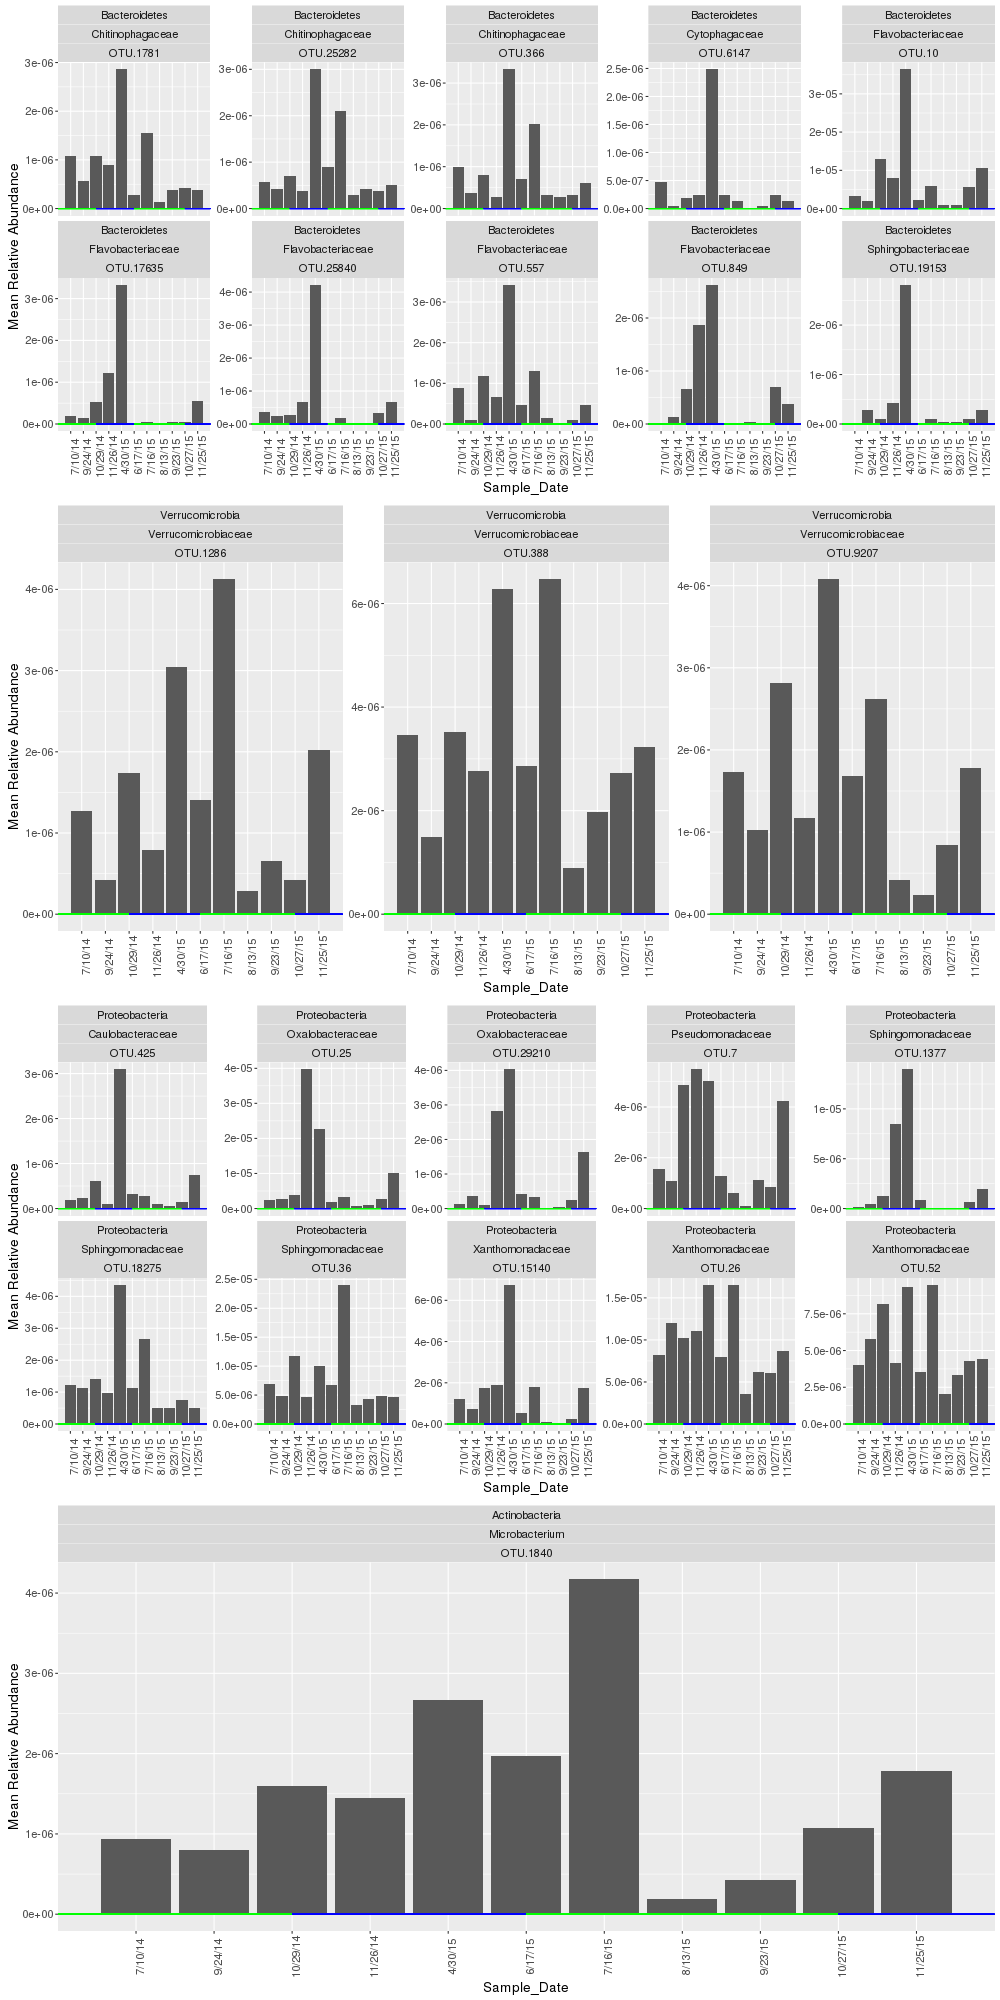

In [83]:
%%R -w 1000 -h 2000

NTR.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'NTR')

phylum = unique(NTR.NTR.bulk.mean$Rank2)

make_plot = function(df, phylum) {
    
    plot.d = df %>% filter(Rank2 == phylum)
    date.list = c('10/29/14','11/26/14', '4/30/15', '10/27/15', '11/26/14')
    line1 = filter(plot.d, !(Sample_Date %in% date.list))
    line2 = filter(plot.d, Sample_Date %in% c('10/29/14','11/26/14', '4/30/15'))


   p =  ggplot(plot.d) +
    geom_bar(aes(x = Sample_Date, y = sumAb), stat = 'identity') +
    facet_wrap(Rank2 + Rank5~OTU , ncol = 5, scales = 'free_y') + 
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) + 
        ylab('Mean Relative Abundance') +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')
    
    p
    
    }

plots.NTR = lapply(phylum, make_plot, df = NTR.NTR.bulk.mean)

p = do.call(grid.arrange, c(plots.NTR,list(ncol=1)))

In [84]:
%%R
ggsave('data/figs/RAOTU_fams.png', width = 10, height = 20)

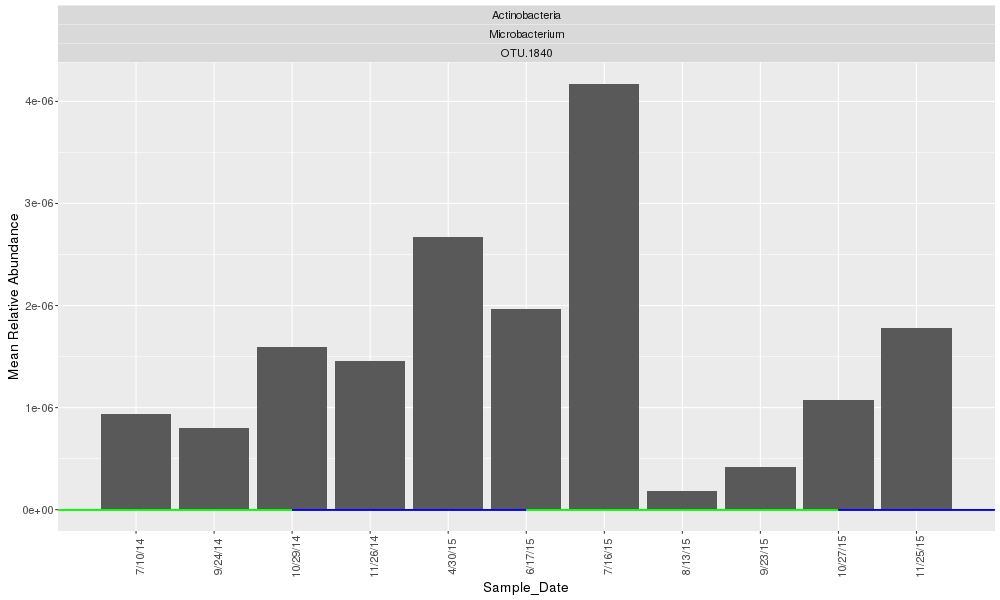

In [98]:
%%R -w 1000 -h 600

NTR.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'NTR')


plot.d = NTR.NTR.bulk.mean %>% filter(Rank2 == "Actinobacteria")

   p =  ggplot(plot.d) +
    geom_bar(aes(x = Sample_Date, y = sumAb), stat = 'identity') +
    facet_wrap(Rank2 + Rank5~OTU , ncol = 5, scales = 'free_y') + 
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) + 
        ylab('Mean Relative Abundance') +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')
    
    p
    


In [100]:
%%R
ggsave('data/figs/ActinosRA.jpg', width = 8, height = 4)

In [73]:
%%R
head(NTR.NTR.bulk.mean)

Source: local data frame [6 x 6]
Groups: Sample_Date, Land_Management, OTU, Rank5 [6]

  Sample_Date Land_Management       OTU               Rank5           Rank2
       (fctr)          (fctr)    (fctr)               (chr)           (chr)
1     7/10/14             NTR    OTU.10   Flavobacteriaceae   Bacteroidetes
2     7/10/14             NTR  OTU.1286 Verrucomicrobiaceae Verrucomicrobia
3     7/10/14             NTR  OTU.1377   Sphingomonadaceae  Proteobacteria
4     7/10/14             NTR OTU.15140    Xanthomonadaceae  Proteobacteria
5     7/10/14             NTR OTU.17635   Flavobacteriaceae   Bacteroidetes
6     7/10/14             NTR  OTU.1781    Chitinophagaceae   Bacteroidetes
Variables not shown: sumAb (dbl)


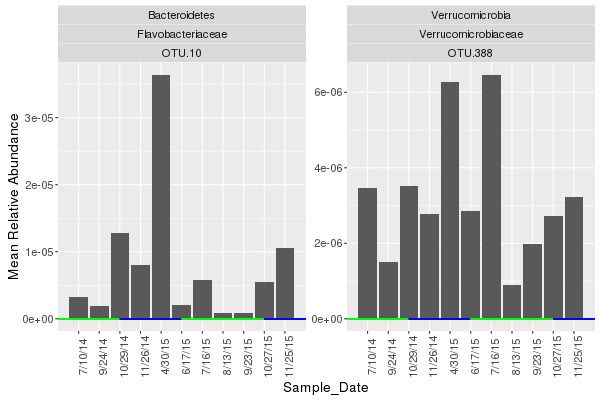

In [86]:
%%R -w 600 -h 400

NTR.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'NTR' & OTU %in% c('OTU.10', 'OTU.388'))


#plot.d = NTR.NTR.bulk.mean %>% filter(Rank2 == "Actinobacteria")

   p =  ggplot(NTR.NTR.bulk.mean) +
    geom_bar(aes(x = Sample_Date, y = sumAb), stat = 'identity') +
    facet_wrap(Rank2 + Rank5~OTU , ncol = 5, scales = 'free_y') + 
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) + 
        ylab('Mean Relative Abundance') +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')
    
    
    p
    


In [89]:
%%R
ggsave('data/figs/OTU10_388.jpg', width = 8, height = 4)

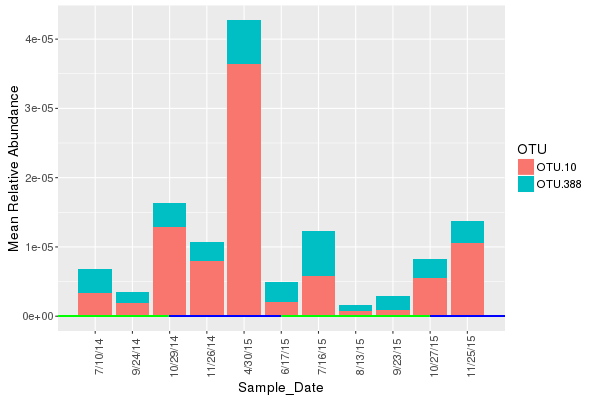

In [75]:
%%R -w 600 -h 400

NTR.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'NTR' & OTU %in% c('OTU.10', 'OTU.388'))


#plot.d = NTR.NTR.bulk.mean %>% filter(Rank2 == "Actinobacteria")

   p =  ggplot(NTR.NTR.bulk.mean) +
    geom_bar(aes(x = Sample_Date, y = sumAb, fill = OTU), stat = 'identity') +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) + 
        ylab('Mean Relative Abundance') +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')
    
    
    p
    


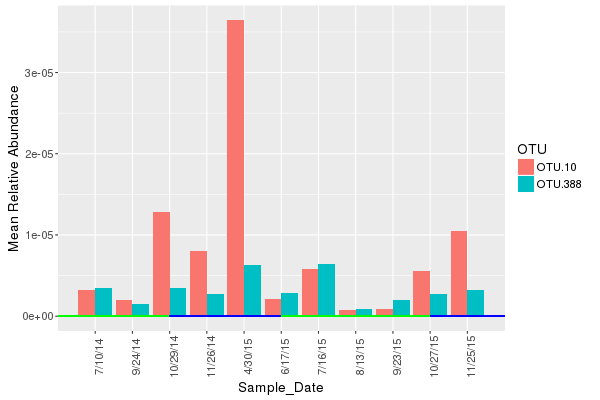

In [76]:
%%R -w 600 -h 400

NTR.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'NTR' & OTU %in% c('OTU.10', 'OTU.388'))


#plot.d = NTR.NTR.bulk.mean %>% filter(Rank2 == "Actinobacteria")

   p =  ggplot(NTR.NTR.bulk.mean) +
    geom_bar(aes(x = Sample_Date, y = sumAb, fill = OTU), stat = 'identity', position = 'dodge') +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) + 
        ylab('Mean Relative Abundance')+
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')
    
    p
    


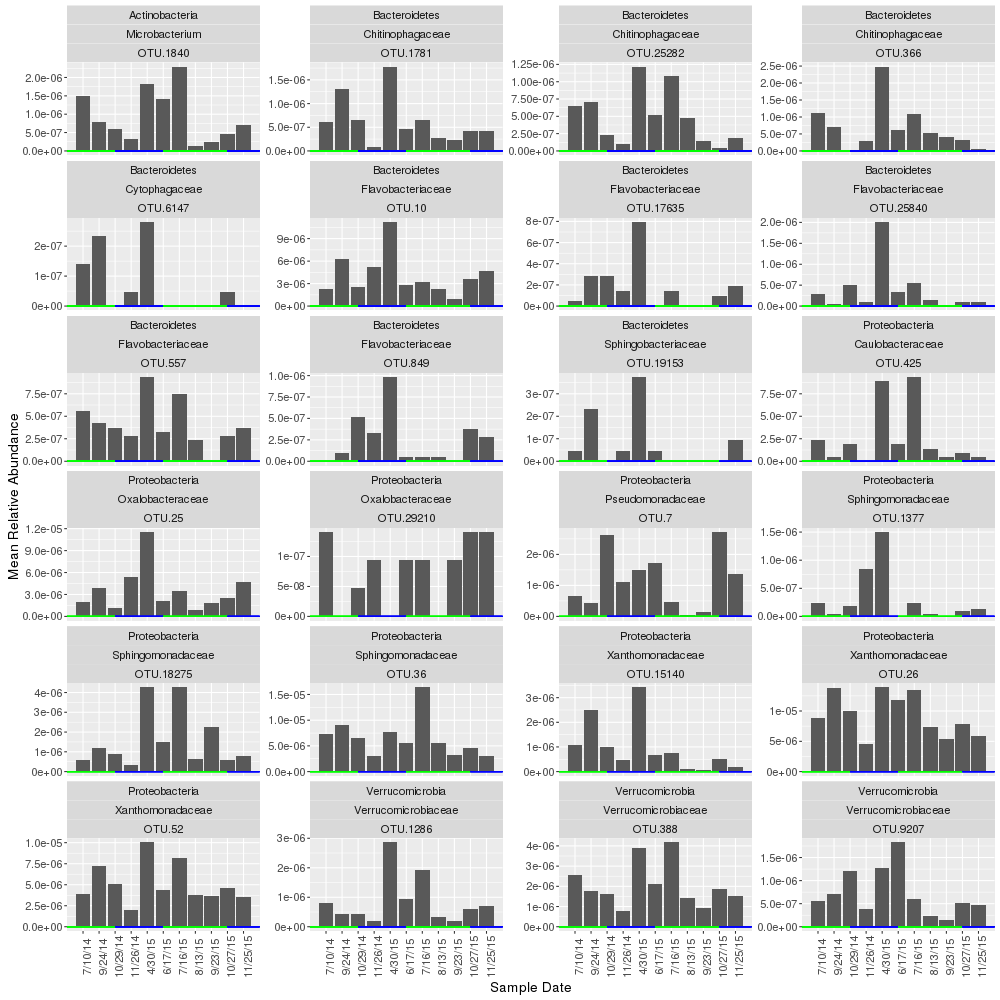

In [108]:
%%R -w 1000 -h 1000

NTH.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'NTH')

p = ggplot(NTH.NTR.bulk.mean) +
    geom_bar(aes(x = Sample_Date, y = sumAb), stat = 'identity') +
    facet_wrap(~Rank2 + Rank5+OTU , ncol = 4, scales = 'free_y') + 
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1))  +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')+ xlab('Sample Date') +
        ylab('Mean Relative Abundance')

    

p

In [109]:
%%R
ggsave('data/figs/RA_NTH.jpg', width = 12, height = 12)

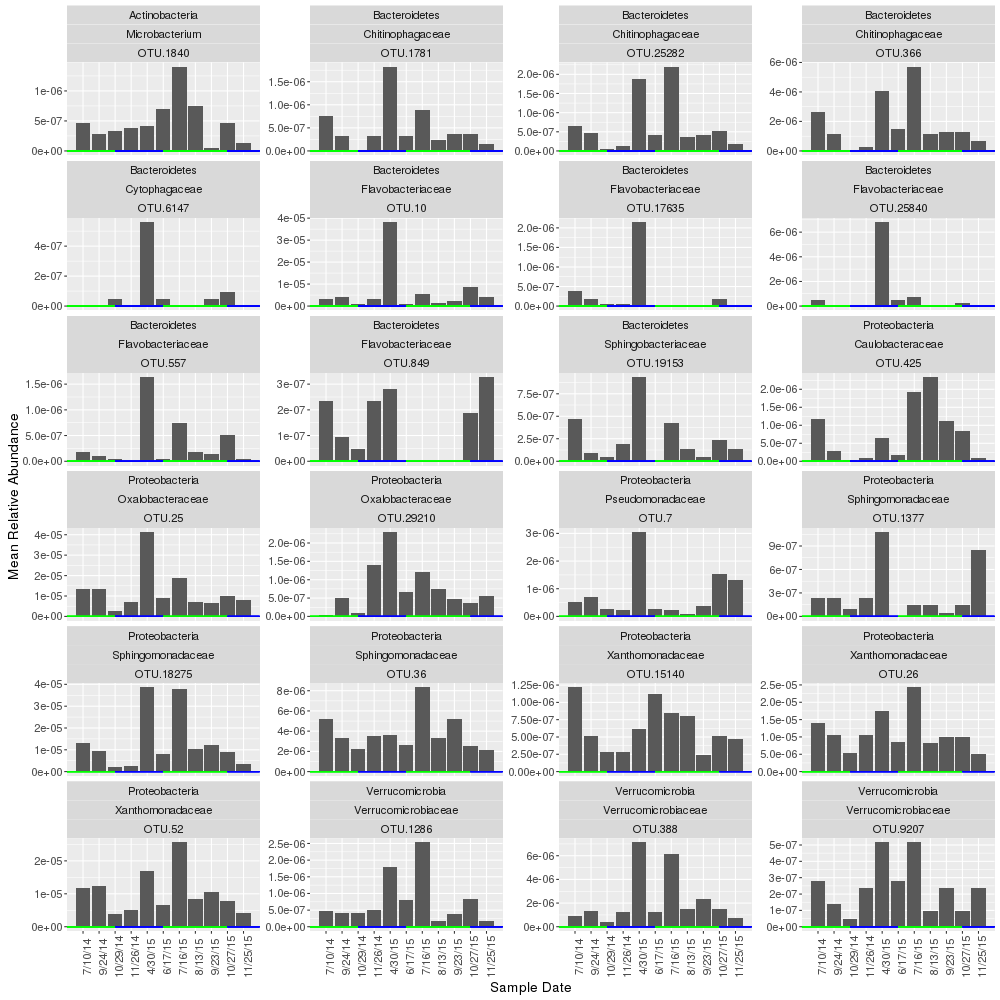

In [110]:
%%R -w 1000 -h 1000

PTH.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'PTH')

p = ggplot(PTH.NTR.bulk.mean) +
    geom_bar(aes(x = Sample_Date, y = sumAb), stat = 'identity') +
    facet_wrap(~Rank2 + Rank5+OTU , ncol = 4, scales = 'free_y') + 
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1))  +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue') + xlab('Sample Date') +
        ylab('Mean Relative Abundance')


p

In [111]:
%%R
ggsave('data/figs/RA_PTH.jpg', width = 12, height = 12)

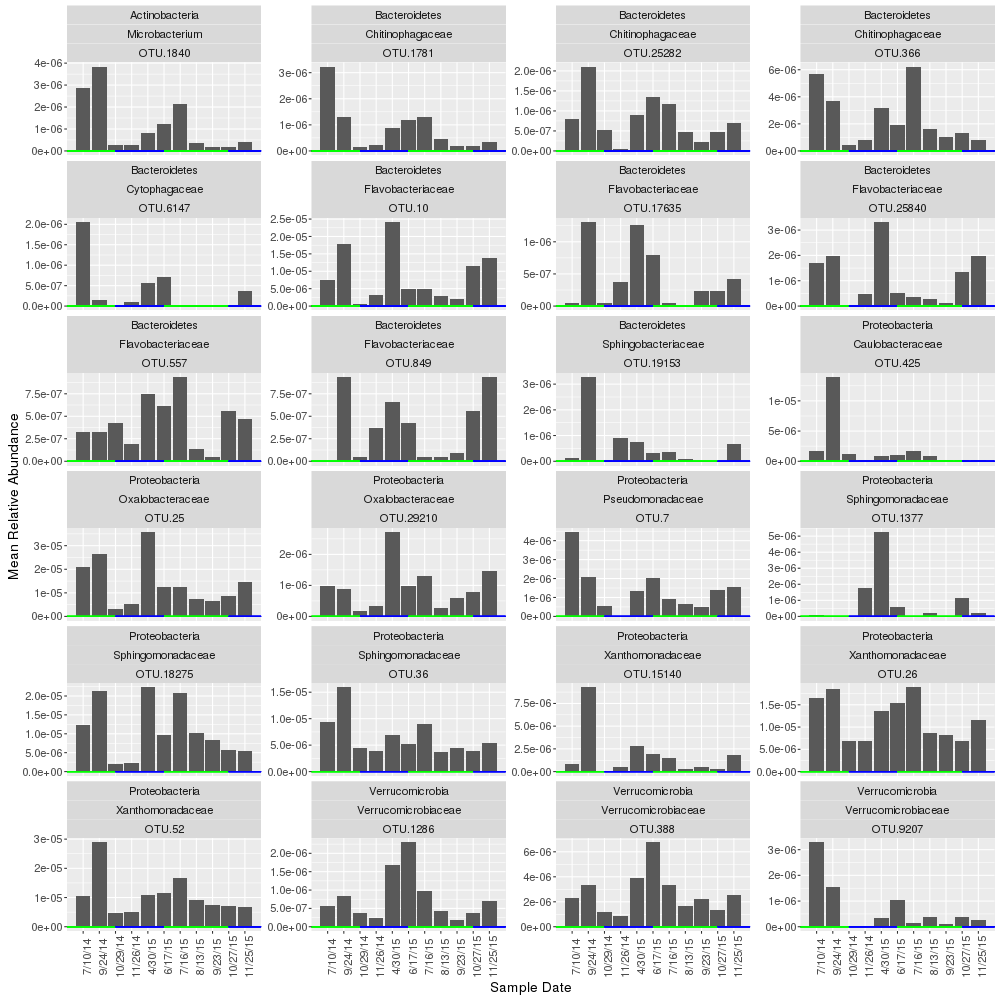

In [112]:
%%R -w 1000 -h 1000

PTR.NTR.bulk.mean = filter(NTR.bulk.mean, Land_Management == 'PTR')

p = ggplot(PTR.NTR.bulk.mean) +
    geom_bar(aes(x = Sample_Date, y = sumAb), stat = 'identity') +
    facet_wrap(~Rank2+Rank5+OTU , ncol = 4, scales = 'free_y') + 
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1))  +
        geom_segment(aes(x=0, xend=3, y=0, yend=0), color = 'green') +
        geom_segment(aes(x=3, xend=6, y=0, yend=0), color = 'blue') +
        geom_segment(aes(x=6, xend=10, y=0, yend=0), color = 'green')+
        geom_segment(aes(x=10, xend=12, y=0, yend=0), color = 'blue')+ xlab('Sample Date') +
        ylab('Mean Relative Abundance')

    

p

In [113]:
%%R
ggsave('data/figs/RA_PTR.jpg', width = 12, height = 12)